#Projet Big Data :

##Cylia LAOUFI
##Jalal MAIMOUNI
##Nassima EL JAZOULI

L'objectif de ce projet est d'explorer plusieurs méthodes ayant pour but commun de classifier des points de manière non supervisée. Nous avons choisi d'étudier l'algorithme K-means. Chaque section du projet représente une approche différente de sa mise en œuvre, sans qu'aucune ne soit universellement supérieure aux autres. En effet, chaque méthode fait des choix distincts pour répondre à des contraintes spécifiques.

#Install Packages

In [ ]:
! pip install -q apache-beam

#Import Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from numpy import sqrt, square, pi, exp, zeros, linspace
from copy import deepcopy
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi
from statistics import mean
import apache_beam as beam
from apache_beam.transforms.userstate import BagStateSpec

#Partie A : Implémentation de k-means séquentiel (Python)

Cette section du projet vise à développer une implémentation séquentielle de l'algorithme k-means en utilisant Python. L'objectif principal est de générer un ensemble de données avec deux classes de points, puis d'appliquer l'algorithme k-means séquentiellement. Les centres initiaux sont choisis aléatoirement parmi les premiers points du jeu de données, et l'algorithme met à jour ces centres et les effectifs des classes associées à chaque nouveau point. Les résultats sont enregistrés de manière à minimiser l'utilisation de la mémoire, et la cohérence des clusters formés est validée par des mesures d'évaluation ou des visualisations. Cette partie met en évidence l'efficacité de l'algorithme k-means dans un contexte séquentiel, avec une attention particulière portée à la gestion optimale de la mémoire, même pour des volumes de données substantiels.

## Génération des données

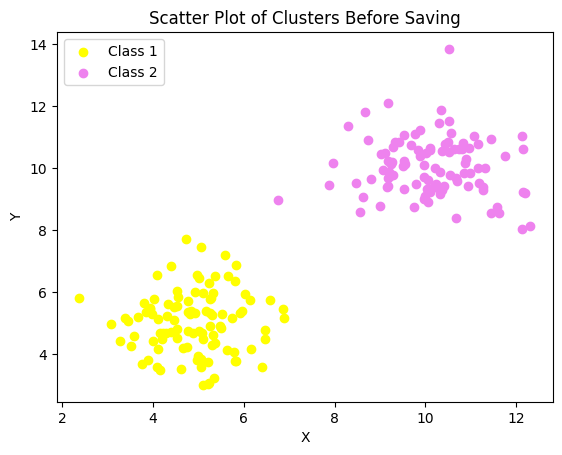

In [ ]:
# Générer des données pour deux classes
np.random.seed(42)

class_1 = np.random.randn(100, 2) + np.array([5, 5])
class_2 = np.random.randn(100, 2) + np.array([10, 10])

# Concaténer les deux classes
data = np.vstack((class_1, class_2))


# Create labels for the two classes (0 for class_1, 1 for class_2)
labels_class_1 = np.zeros(100)
labels_class_2 = np.ones(100)


# Concatenating labels to create 'y' column
y = np.concatenate((labels_class_1, labels_class_2))

y = y.reshape(-1, 1)
# Concatenate 'data' and 'y' horizontally
data= np.hstack((data, y))

# Plot clusters with different colors
plt.scatter(class_1[:, 0], class_1[:, 1], color='yellow', label='Class 1')
plt.scatter(class_2[:, 0], class_2[:, 1], color='Violet', label='Class 2')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot of Clusters Before Saving')
plt.legend()
plt.show()

In [ ]:
# Enregistrer les données dans un DataFrame et dans un fichier CSV
data=data.round(decimals = 2)
np.random.shuffle(data)
y = data[:, 2]
print(data)
df = pd.DataFrame(data, columns=['x1', 'x2','y'])
df = df.drop(columns='y')
# Shuffle the rows of the DataFrame
shuffled_data = df.sample(frac=1).reset_index(drop=True)
df.to_csv('data_points.csv', index=False)

[[ 6.4   3.6   0.  ]
 [ 4.81  5.3   0.  ]
 [ 6.47  4.77  0.  ]
 [10.32  9.17  1.  ]
 [ 5.21  3.75  0.  ]
 [ 5.92  5.33  0.  ]
 [ 5.06  3.86  0.  ]
 [ 9.27 10.22  1.  ]
 [ 9.34 10.85  1.  ]
 [ 9.68 10.76  1.  ]
 [ 5.81  6.36  0.  ]
 [ 9.07  9.94  1.  ]
 [ 5.01  6.45  0.  ]
 [ 9.02 10.46  1.  ]
 [ 4.52  4.81  0.  ]
 [12.13  8.05  1.  ]
 [ 5.28  5.83  0.  ]
 [10.07  9.61  1.  ]
 [ 4.11  4.18  0.  ]
 [ 5.23  6.31  0.  ]
 [ 4.54  6.06  0.  ]
 [ 5.1   4.5   0.  ]
 [ 5.09  3.01  0.  ]
 [10.83 10.81  1.  ]
 [ 9.98  9.    1.  ]
 [ 9.79  9.51  1.  ]
 [ 9.98 10.12  1.  ]
 [ 5.25  5.35  0.  ]
 [ 3.99  5.31  0.  ]
 [10.41  9.44  1.  ]
 [10.44 10.77  1.  ]
 [ 8.29 11.35  1.  ]
 [10.05  9.35  1.  ]
 [ 3.67  5.2   0.  ]
 [ 4.46  5.11  0.  ]
 [ 4.78  5.36  0.  ]
 [11.16 10.79  1.  ]
 [ 4.32  5.23  0.  ]
 [10.52 13.85  1.  ]
 [ 9.17  9.68  1.  ]
 [ 9.56 10.13  1.  ]
 [10.24  9.49  1.  ]
 [ 4.09  3.59  0.  ]
 [10.55  9.8   1.  ]
 [ 4.96  6.56  0.  ]
 [10.69  9.6   1.  ]
 [ 4.4   4.71  0.  ]
 [ 5.36  4.35

##k-means séquentiel

In [ ]:
def kmeans_sequential(reader,k):
    first=True
    all_clusters = np.array([])
    for chunk in reader:
          chunk_np = chunk.values  # Convert chunk to numpy array
          n_points = chunk_np.shape[0]
          cluster = np.zeros(n_points)

          if (first):
              centroids = chunk_np[np.random.choice(n_points, k, replace=False)]
              n = np.zeros(k)
              first=False

          print(centroids)
          for i, row in enumerate(chunk_np):
              min_dist = float('inf')
              id = None
              for idx, centroid in enumerate(centroids):
                  # Euclidean distance calculation
                  d = np.linalg.norm(centroid - row)

                  if min_dist > d:
                      min_dist = d
                      id = idx

              cluster[i] = id
              n[id] += 1

              # Update centroid by considering all dimensions
              centroids[id] = centroids[id] + (1.0 / n[id]) * (row - centroids[id])
          all_clusters = np.append(all_clusters, cluster)
    return centroids, all_clusters

In [ ]:
# Charger les données pour l'algorithme k-means
reader = pd.read_csv('data_points.csv', chunksize=50)

# Appliquer l'algorithme k-means
centroids, clusters = kmeans_sequential(reader,k=2)
print("Centres finaux des clusters:", centroids)

[[ 5.01  6.45]
 [ 8.29 11.35]]
[[ 4.98692308  4.94884615]
 [10.05458333 10.14      ]]
[[ 5.06705882  5.08313725]
 [10.20979592 10.09204082]]
[[ 4.95540541  5.06324324]
 [10.11921053 10.065     ]]
Centres finaux des clusters: [[ 4.8847  5.0339]
 [10.128  10.0433]]


##Mesure de performance

In [ ]:
y = y.flatten()
print("Normalized Mutual Information:", nmi(y,clusters))

Normalized Mutual Information: 1.0


#Partie B : Implémentation d’une version streaming de k-means (Python)

Dans cette partie une version streaming de l'algorithme K-means est implémentée. Les paramètres essentiels sont définis, tels que le nombre maximal de batches à conserver (T), le paramètre de pondération pour déterminer l'importance de l'historique (r), le nombre de clusters (k), la taille de chaque batch (BATCH_SIZE), et la dimension des caractéristiques (FEATURE_SIZE). La fonction streaming_kmeans prend en compte ces paramètres pour mettre à jour les centroides au fur et à mesure de l'arrivée de nouveaux batches.

In [ ]:
T = 5 # Nombre maximal de batches à conserver
r = 0.7 # Paramètre de pondération pour déterminer l'importance de l'historique
k = 2  # Nombre de clusters
BATCH_SIZE = 50  # Taille de chaque batch
FEATURE_SIZE = 2  # Feature Dimension

batch_weighting = [r**i for i in range(T-1, -1, -1)]  # Ordre inverse

def streaming_kmeans(X, P, B0):
    if len(X) == T:
        X = X[1:]  # Supprimer le premier batch (le plus ancien)
    X.append(B0)

    input_values_dims = (BATCH_SIZE * len(X), FEATURE_SIZE)
    weights = []
    X_concatenated = None

    for i, batch in enumerate(X):
        current_batch_weights = [batch_weighting[i]] * batch.shape[0]
        weights.extend(current_batch_weights)

        if X_concatenated is None:
            X_concatenated = batch
        else:
            X_concatenated = np.concatenate((X_concatenated, batch))

    kmeans = KMeans(n_clusters=k, init=P, random_state=42, n_init=1).fit(X_concatenated, sample_weight=weights)
    centroids = kmeans.cluster_centers_
    partition = kmeans.labels_

    return [centroids, partition, X_concatenated]

In [ ]:
batch_weighting

[0.24009999999999995, 0.3429999999999999, 0.48999999999999994, 0.7, 1.0]

Maintenant, nous générons un jeu de données initial avec deux clusters définis par les centres (5, 5) et (10, 10). Ces données sont ensuite divisées en 20 batches, et le processus de streaming K-means est appliqué à ces batches avec une mise à jour des centroides à chaque itération.

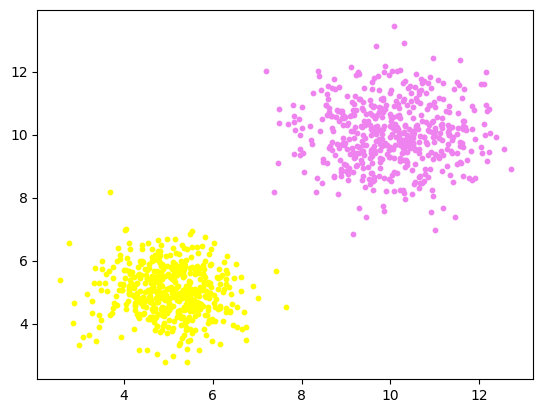

In [ ]:
# Génération du jeu de données initial
centers = [(5, 5), (10, 10)]
cluster_std = [0.8, 1]
X, y = make_blobs(n_samples=1000, cluster_std=cluster_std, centers=centers, random_state=1)

# Affichage des clusters initiaux
plt.scatter(X[y == 0, 0], X[y == 0, 1], color="yellow", s=10, label="Cluster1")
plt.scatter(X[y == 1, 0], X[y == 1, 1], color="Violet", s=10, label="Cluster2")


Puis nous divisons les 1000 points sont divisés en 20 batchs. Il s'agit d'un choix spécifique fait pour gérer le processus de streaming K-means de manière itérative. Chaque itération utilise un batch de données, et en divisant les 1000 points en 20 batches, on peut appliquer l'algorithme de manière incrémentale, en prenant un batch à la fois. Ceci nous aidera de gérer la mémoire de manière plus efficace, en ne chargeant qu'une petite partie des données à la fois et nous facilitera l'évaluation incrémentale si besoin

In [ ]:
# Division des 1000 points en 20 batches
batches = np.split(X, 20)
print(len(batches))
print(batches[0].shape)

20
(50, 2)


In [ ]:
# Initialisation des centroides avec des points aléatoires de X
centroids_idx = np.random.choice(X.shape[0], k)
centroids = X[centroids_idx, ]
centroids

array([[5.88178939, 4.0163406 ],
       [4.93239358, 4.76211049]])

In [ ]:
# Fonction pour évaluer le clustering en 2D
def eval_clustering_2D(X, full_points, labels):
  plt.figure(figsize = (6, 4))
  plt.title("Clusters")
  plt.scatter(x = full_points[:, 0], y = full_points[:, 1], color="red")
  plt.scatter(x = X[:, 0], y = X[:, 1], c = labels)
  plt.show()

Iteration  0


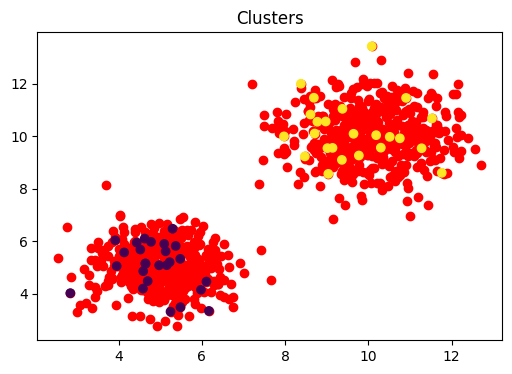

Iteration  4


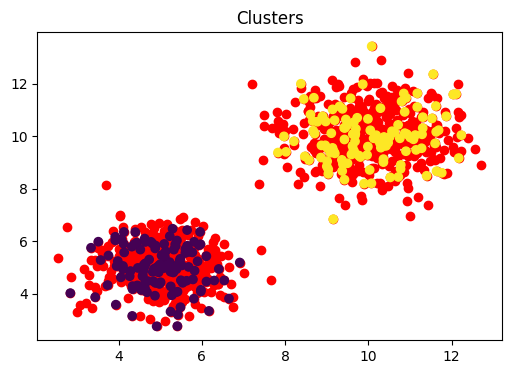

Iteration  8


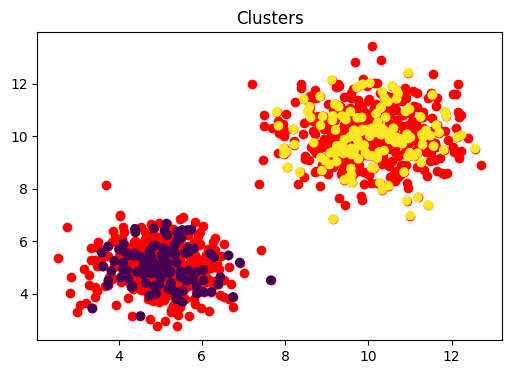

Iteration  12


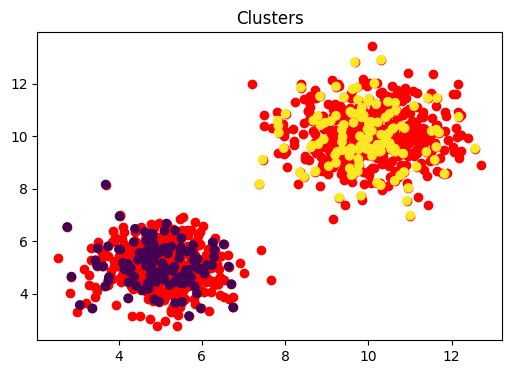

Iteration  16


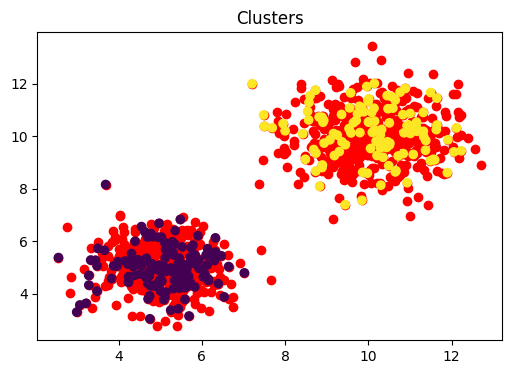

In [ ]:
# Initialisation des centroides avec des points aléatoires de X
centroids_idx = np.random.choice(X.shape[0], k)
centroids = X[centroids_idx, ]
old_batches = []

# Application de l'algorithme de streaming K-means avec mise à jour des centroides à chaque itération
for i in range(20):
    oldest_index = max(0, i-5)
    previous_batches = batches[oldest_index:i]
    res = streaming_kmeans(previous_batches, centroids, batches[i])
    centroids = res[0]
    new_partition = res[1]

    if i % 4 == 0:
        print("Iteration ", i)
        # Affichage de l'ensemble des données en rouge
        # Les points colorés sont la partition retournée par streaming_kmeans pour les batches actuels
        eval_clustering_2D(res[2], X, new_partition)  # évaluation du clustering en 2D


Nous allons maintenant générer un nouveau jeu de données avec une distribution qui change au fil du temps  pour simuler des scénarios dans lesquels les caractéristiques statistiques des données évoluent avec le temps. Ceci nous permettra d'étudier, entre autres, le comportement dynamique des algorithmes et tester notre algorithme de streaming

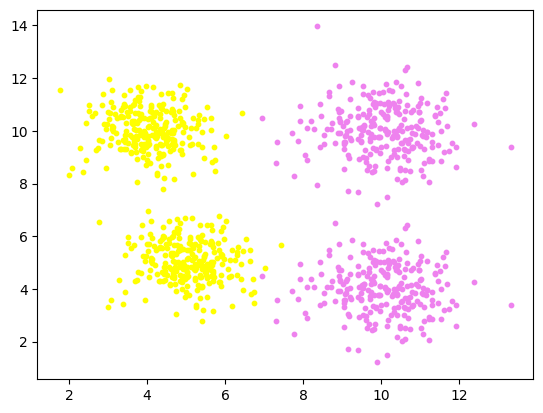

In [ ]:
# Fonction de génération d'un nouveau jeu de données avec distribution changeante
def generate_dynamic_dataset():
    centers = [(5, 5), (10, 10)]
    cluster_std = [0.8, 1]

    X1, y1 = make_blobs(n_samples=500, cluster_std=cluster_std, centers=centers, random_state=1)

    new_centers = [(4, 10), (10, 4)]

    X2, y2 = make_blobs(n_samples=500, cluster_std=cluster_std, centers=new_centers, random_state=1)

    X_tot = np.concatenate((X1, X2))
    y_tot = np.concatenate((y1, y2))

    return X_tot, y_tot

# Fonction pour initialiser les centroids
def initialize_centroids(X, k):
    centroids_idx = np.random.choice(X.shape[0], k)
    centroids = X[centroids_idx, :]
    return centroids

# Génération du jeu de données
X_tot, y_tot = generate_dynamic_dataset()

# Affichage du jeu de données initial
plt.scatter(X_tot[y_tot == 0, 0], X_tot[y_tot == 0, 1], color="Yellow", s=10, label="Cluster 1")
plt.scatter(X_tot[y_tot == 1, 0], X_tot[y_tot == 1, 1], color="Violet", s=10, label="Cluster 2")
plt.show()

In [ ]:
# Division du jeu de données en batches
batches = np.split(X_tot, 20)
print(len(batches))
print(batches[0].shape)


20
(50, 2)


In [ ]:
# Initialisation des centroids
centroids = initialize_centroids(X_tot, k)

# Paramétrage du poids des batches
batch_weighting = [r**i for i in range(T-1, -1, -1)]


Iteration  0


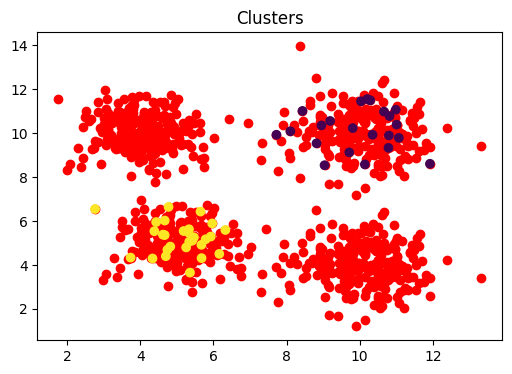

Iteration  2


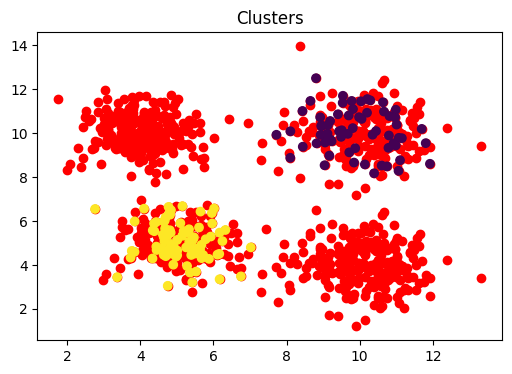

Iteration  4


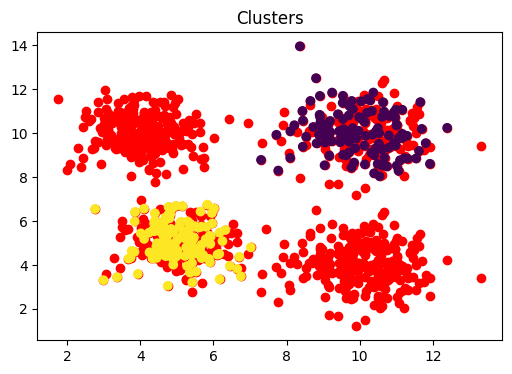

Iteration  6


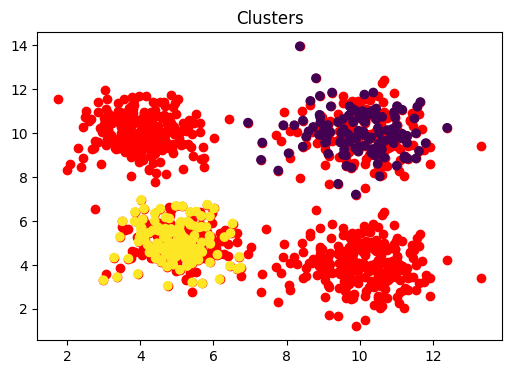

Iteration  8


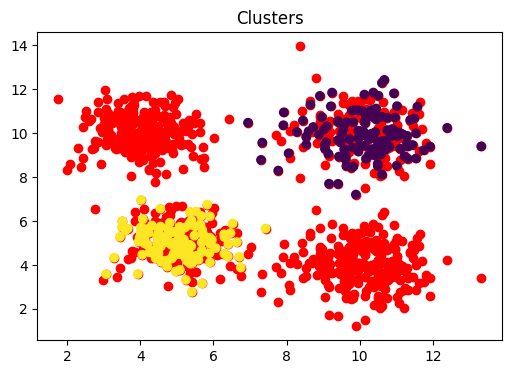

Iteration  10


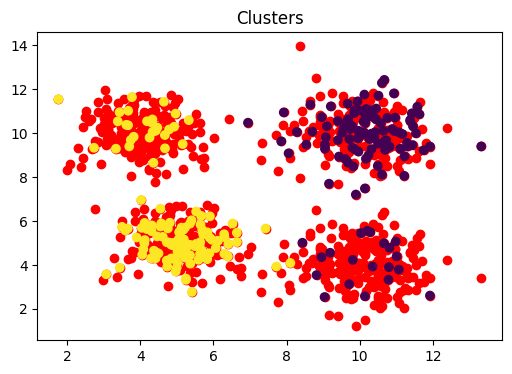

Iteration  12


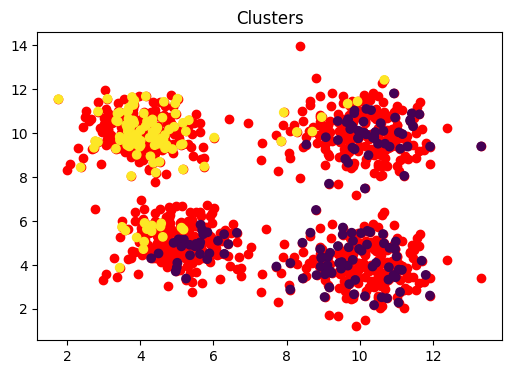

Iteration  14


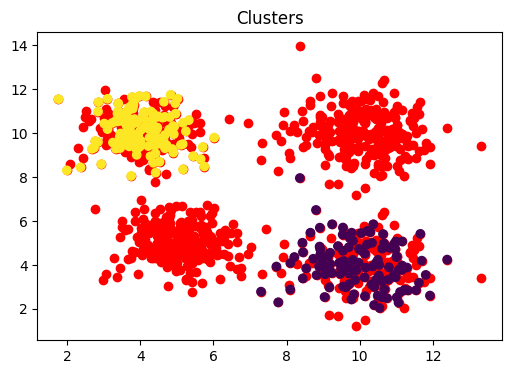

Iteration  16


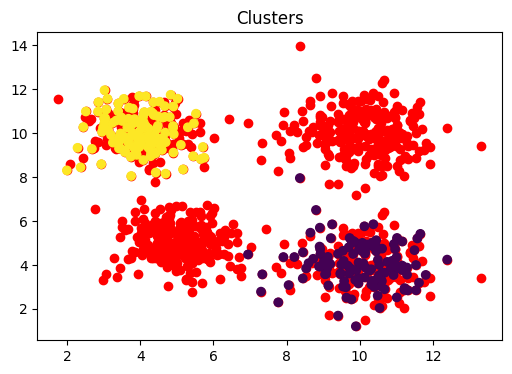

Iteration  18


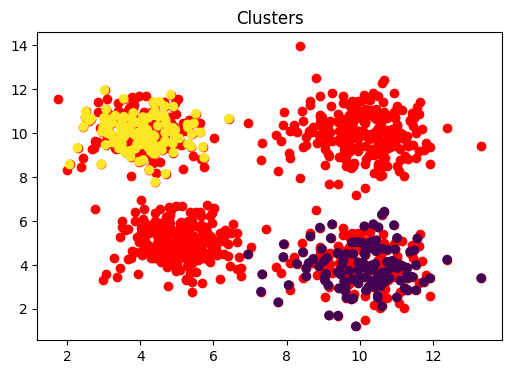

In [ ]:
# Application de l'algorithme de streaming K-means avec mise à jour des centroides
for i in range(20):
    oldest_index = max(0, i-5)
    previous_batches = batches[oldest_index:i]
    res = streaming_kmeans(previous_batches, centroids, batches[i])
    centroids = res[0]
    new_partition = res[1]

    if i % 2 == 0:
        print("Iteration ", i)
        # Affichage de l'ensemble des données en gris
        # Les points colorés sont la partition retournée par streaming_kmeans pour les batches actuels
        eval_clustering_2D(res[2], X_tot, new_partition)

L'observation de la transition à l'itération 14 suggère que le modèle est en train de s'ajuster aux nouvelles caractéristiques du jeu de données. Cette période de transition est visualisée en examinant l'évolution des clusters et des centroides à chaque itération. Cette transition est ainsi visible dans la manière dont les centroides changent et comment les points sont affectés à ces centroides.

Maintenant nous allons paramétrer le r à 1. Cela signifie que tous les batches précédents ont le même poids que le batch actuel lors de la mise à jour des centroides.

Iteration  0


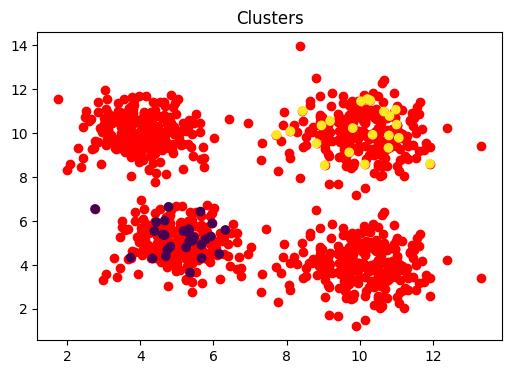

Iteration  2


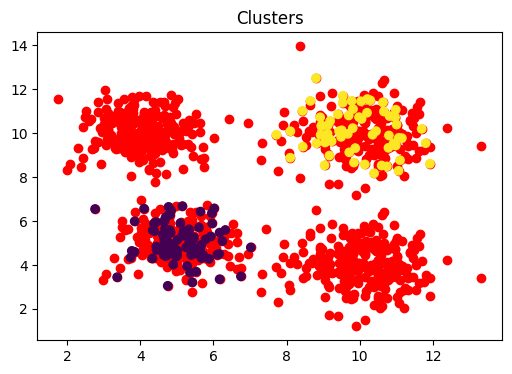

Iteration  4


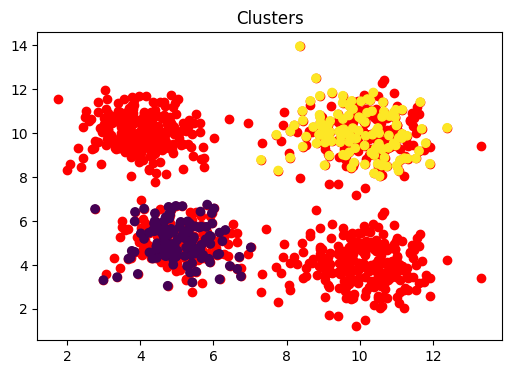

Iteration  6


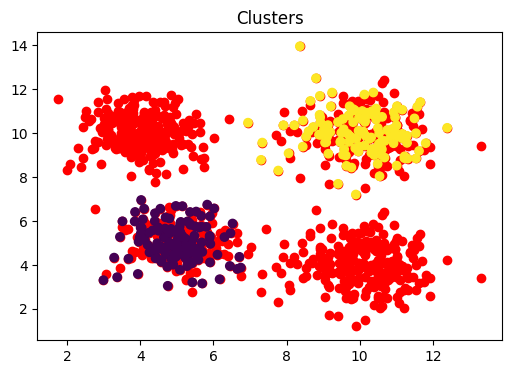

Iteration  8


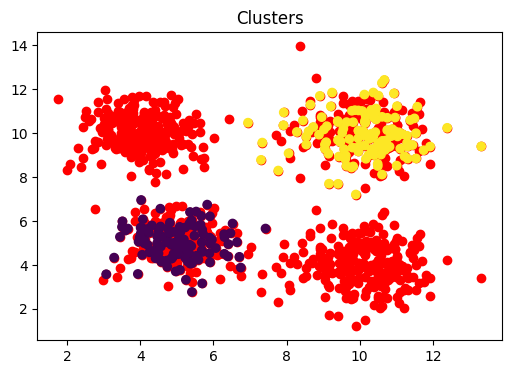

Iteration  10


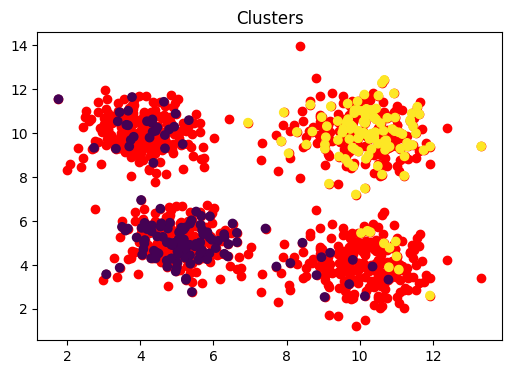

Iteration  12


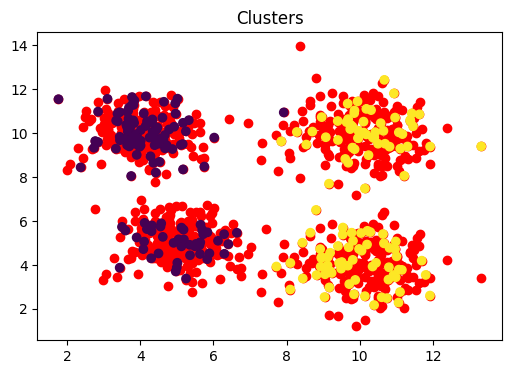

Iteration  14


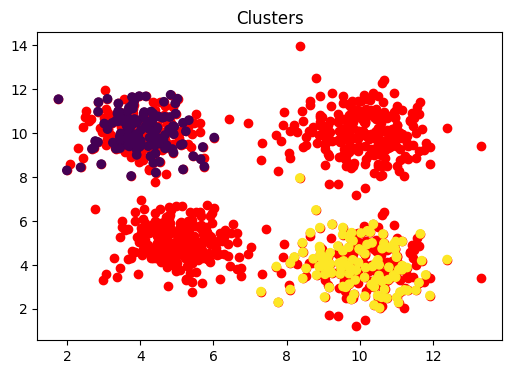

Iteration  16


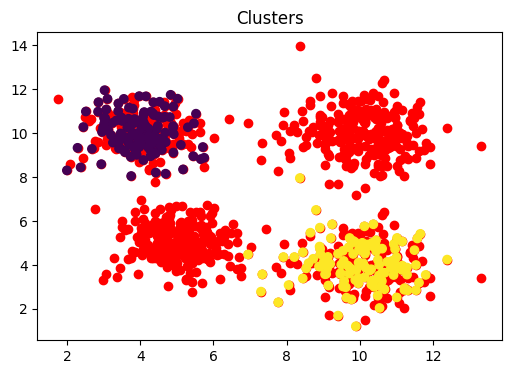

Iteration  18


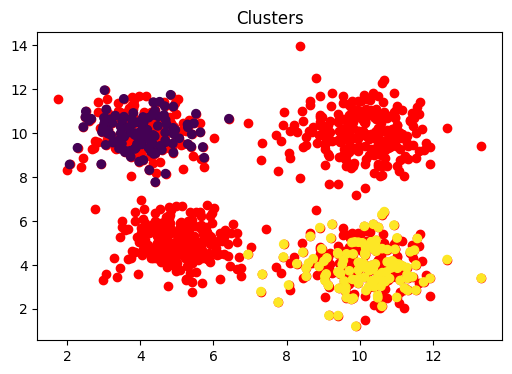

In [ ]:
# Paramétrage
r = 1
batch_weighting = [r**i for i in range(T-1, -1, -1)]

# Initialisation des centroides avec des points aléatoires de X_tot
centroids_idx = np.random.choice(X_tot.shape[0], k)
centroids = X_tot[centroids_idx, ]
old_batches = []

# Application de l'algorithme de streaming K-means avec mise à jour des centroides à chaque itération
for i in range(20):
    oldest_index = max(0, i-5)
    previous_batches = batches[oldest_index:i]
    res = streaming_kmeans(previous_batches, centroids, batches[i])
    centroids = res[0]
    new_partition = res[1]
    if i % 2 == 0:
        print("Iteration ", i)
        # Affichage des résultats
        eval_clustering_2D(res[2], X_tot, new_partition)


Nous remarquons que lorsque le paramètre r est égal à 1, les centroides calculés par l'algorithme de streaming K-means ont du mal à s'adapter rapidement aux changements dans la distribution des données. En effet, avec un r=1 : Les centroides ne sont pas fortement influencés par les batches les plus récents, ce qui signifie que l'algorithme attribue autant d'importance aux batches plus anciens qu'aux batches plus récents. Cela conduit à une sorte de "balancement" entre les caractéristiques des anciens batches et celles des nouveaux batches, rendant les mises à jour des centroides moins sensibles aux changements. Alors qu'avec un r plus petit : Les centroides sont davantage influencés par les batches les plus récents. Cela favorise une adaptation plus rapide aux changements dans la distribution des données. L'algorithme accorde moins d'importance aux caractéristiques des batches plus anciens, permettant aux centroides de mieux refléter la distribution actuelle des données.
Ainsi, à l'itération 14, avec r=1, le clustering résultant semble être un compromis entre l'ancienne et la nouvelle distribution. En revanche, avec un r plus petit, le clustering reflète davantage la nouvelle distribution, indiquant une adaptation plus rapide aux changements. Cette observation souligne l'impact significatif du paramètre r sur la capacité de l'algorithme à s'ajuster dynamiquement aux évolutions dans les données au fil du temps.

#Partie C : Implémentation de k-means distribué (Apache Beam)

Dans cette section, nous abordons l'implémentation distribuée de l'algorithme K-means à l'aide d'Apache Beam. Notre approche se concentre initialement sur des données unidimensionnelles, où chaque point est caractérisé par une seule coordonnée.

In [ ]:
# Génération de données unidimensionnelles
a = np.random.rand(200)

In [ ]:
def create_tuples(text):
  clusters=[0,1]

  t = (int(np.random.choice(clusters)),text)
  return  t
output = []
def collect(row):
    output.append(row)
    return True
def calcul_centroid(elt):
  c=[]

  for e in elt:
    c.append(e[1])
  return (elt[0][0], mean(c))

Nous allons commencer par créer la PCollection 'lines', qui renferme l'ensemble des points. Cette PCollection est soumise à une transformation qui attribue à chaque point un cluster, représenté sous la forme d'un tuple.
En suuite, nous établissons la PCollection 'centroids', dédiée au calcul des coordonnées des centroides pour chaque cluster. Ces coordonnées sont exprimées sous forme de tuples, résultant d'une séquence de transformations.
Par la suite, nous mettons en œuvre l'étape de partitionnement en élaborant la fonction 'assign_cluster'. Cette fonction est utilisée pour assigner à chaque point son numéro de cluster, et les résultats sont enregistrés dans la PCollection 'partition'. Dans cette partie, nous supposons que chaque élément de la PCollection 'centroids' est un tuple, où le premier élément sert de clé et le second comme valeur.
Enfin, la sortie de cette étape consiste en un tuple comprenant le numéro du cluster et la coordonnée du point.

In [ ]:
def assign_cluster(coord, centroids):
  mn_dist = float('inf')
  for key,value in centroids.items():
    d = np.sqrt((value-coord)**2 )
    if mn_dist > d:
      mn_dist = d
      id=key
  return (id,coord)

with beam.Pipeline() as pipeline:
  lines = (
      pipeline
      | 'lines' >> beam.Create(a)
      |'create tuples' >> beam.Map(create_tuples)
      | "print" >> beam.Map(collect))

  centroids = (pipeline | 'Centroidss' >> beam.Create(output)
      | beam.GroupBy(lambda s: s[0])
      | "take one" >> beam.Map(lambda s: s[1])
      | "count mean" >> beam.Map(calcul_centroid))

  partition = (
      pipeline
      | 'Partition' >> beam.Create(a)
      | 'Assign cluster' >> beam.Map(
          assign_cluster,
          centroids=beam.pvalue.AsDict(centroids),
      )
      | beam.Map(print))

(1, 0.14085702037979986)
(1, 0.1763869865062233)
(0, 0.49836777273947974)
(1, 0.4189254495045479)
(0, 0.9148459010681)
(1, 0.3623938991166331)
(0, 0.5805883502780435)
(0, 0.6322642879195304)
(1, 0.013094456588333636)
(0, 0.6635373720167106)
(1, 0.17803596686975143)
(0, 0.9610703174694551)
(1, 0.14866272775311296)
(1, 0.41462412372702373)
(1, 0.08534966807864386)
(0, 0.9968742518459474)
(0, 0.5021950103312426)
(0, 0.5953850173200438)
(1, 0.06707647738842748)
(0, 0.7499604703991778)
(1, 0.20990559309558576)
(0, 0.8980542894407137)
(1, 0.20513964048200717)
(1, 0.19068772066366657)
(1, 0.03654966784809488)
(1, 0.47206694510999925)
(0, 0.5648411332626164)
(1, 0.06570863942835237)
(0, 0.7755276166950106)
(1, 0.4532888347480276)
(0, 0.52439026932758)
(1, 0.44076274693822814)
(1, 0.400763060875326)
(0, 0.5596403313082179)
(1, 0.1552402459307125)
(1, 0.18192813049527112)
(0, 0.8617856210135173)
(0, 0.9461154621336327)
(1, 0.37330931627975295)
(1, 0.27074467314355377)
(0, 0.6439995432390158)
(1,

#Partie D : Implémentation de k-means séquentiel distribuée (Apache Beam)

La section D du projet se concentre sur l'implémentation de l'algorithme k-means séquentiel distribué à l'aide d'Apache Beam. L'objectif est de transformer l'algorithme décrit dans la partie A pour qu'il soit compatible avec le modèle de traitement de données distribué offert par Apache Beam. Le code fourni à titre d'exemple utilise les fonctionnalités d'état de Beam pour démontrer la conservation d'un état partagé entre les éléments de la PCollection. Dans le contexte de l'algorithme k-means séquentiel, cette approche peut être adaptée pour stocker et mettre à jour les centres et les effectifs des classes au fur et à mesure du traitement des données. Initialement, une clé unique peut être utilisée pour maintenir un état partagé, ouvrant la voie à des considérations ultérieures sur l'optimisation de cette stratégie en termes de parallélisation.

Des données sont générées avec deux ensembles de points en utilisant la fonction np.random.uniform.
Ces données sont concaténées pour former la matrice X.

In [ ]:
# Générer des données avec deux ensembles de points
X = np.concatenate([np.random.uniform(5, 1, size=(100, 2)), np.random.uniform(20, 1, size=(100, 2))])

Le nombre de clusters k est défini à 2.
Les centroids sont initialisés de manière aléatoire en choisissant des points aléatoires dans les données générées.

In [ ]:
# Nombre de clusters
k = 2

# Initialiser les centroids de manière aléatoire
centroides_aleatoires = []
indices_disponibles = list(range(1, len(X)))

for i in range(k):
    index = np.random.choice(indices_disponibles)
    centroides_aleatoires.append(X[index])

centroids = np.array(centroides_aleatoires)

Une fonction calculer_cluster_proche est définie pour déterminer le cluster le plus proche d'un point par rapport aux centroids.

In [ ]:
# Fonction pour calculer le cluster le plus proche d'un point
def calculer_cluster_proche(point, centroids):
    distance_minimale = float('inf')
    cluster_plus_proche = None

    for idx, centroid in enumerate(centroids):
        distance = np.sqrt((centroid[0] - point[0])**2 + (centroid[1] - point[1])**2)

        if distance_minimale > distance:
            distance_minimale = distance
            cluster_plus_proche = idx

    return cluster_plus_proche

La classe KmeansSequentielDist est définie en tant que transformation Apache Beam.
Elle maintient les centroids et les compteurs de chaque cluster.
La méthode process est utilisée pour mettre à jour les centroids et les compteurs à mesure que de nouveaux points arrivent.

In [ ]:
# Classe pour l'implémentation séquentielle de K-means avec Apache Beam
class KmeansSequentielDist(beam.DoFn):
    def __init__(self, centroids=centroids):
        self.centroids = centroids
        self.counts = [0, 0]

    def process(self, element):
        # Initialiser les compteurs
        counts = np.zeros((2))
        point = element

        # Trouver le cluster le plus proche
        cluster_alloue = calculer_cluster_proche(point, self.centroids)

        # Mettre à jour les centroids et les compteurs
        for t in range(2):
            self.centroids[cluster_alloue, t] += (point[t] - self.centroids[cluster_alloue, t]) / (self.counts[cluster_alloue] + 1)

        self.counts[cluster_alloue] += 1
        yield cluster_alloue

Une PCollection est créée à partir des données générées.
L'algorithme K-means séquentiel distribué est appliqué en utilisant la transformation beam.ParDo(KmeansSequentielDist()).

In [ ]:
# Créer un pipeline Apache Beam
with beam.Pipeline() as pipeline:
    # Créer une PCollection à partir des données générées
    donnees = pipeline | "Creer" >> beam.Create(X)

    # Appliquer l'algorithme K-means séquentiel distribué
    (donnees
     | "Mise_a_jour_etat" >> beam.ParDo(KmeansSequentielDist())
     | 'Afficher' >> beam.Map(print)
     )

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
1
1
0
1
1
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
1
0
0
0
0
1
0
0
1
1
0
0
0
1
0
0
0
0
0
0
1
1
0
0
0
1
0
0
0
0
1
0
1
1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
1
1
0


####Quel est l'impact d'avoir une seule clé unique (et donc un seul état) en termes de parallélisation ?

Avoir une seule clé unique signifie que toutes les instances de la fonction process partageront le même état. Cela peut entraîner des goulots d'étranglement et limiter la parallélisation, car toutes les mises à jour de l'état doivent être synchronisées. Pour améliorer la parallélisation, on peut envisager d'utiliser plusieurs clés (par exemple, basées sur la fonction de hachage du point) pour répartir les données et réduire les conflits d'accès concurrents à l'état.

####Peut-on optimiser cela ?

Oui, pour optimiser cela, on peut envisager de partitionner les données en utilisant des clés différentes pour répartir la charge entre les différentes instances de la fonction process. Cela permettrait de réduire les conflits d'accès à l'état et d'améliorer la parallélisation.

#Partie E :  Implémentation d’une version streaming et distribuée de k-means (Apache Beam)

La section E du projet vise à mettre en œuvre une version streaming et distribuée de l'algorithme k-means à l'aide d'Apache Beam, conformément à ce qui a été décrit dans la partie B. L'objectif est de s'appuyer sur le même principe que celui utilisé pour la partie D, en conservant les batches dans la variable d'état. Cette approche permet de traiter les données en continu tout en maintenant un état partagé entre les éléments, facilitant ainsi la mise en œuvre d'un algorithme k-means adapté à des données en streaming.

Des données sont générées avec deux clusters en utilisant la fonction make_blobs de scikit-learn.
Les données sont divisées en lots (batches) de taille égale.

In [ ]:
# Paramètres pour la génération des données
centers = [(5, 5), (10, 10)]
cluster_std = [0.8, 1]

# Générer des données avec deux clusters
X, y = make_blobs(n_samples=200, cluster_std=cluster_std, centers=centers, random_state=1)

In [ ]:
# Afficher la forme des données générées
print("Forme des données X :", X.shape)

Forme des données X : (200, 2)


In [ ]:
# Diviser les données en lots (batches)
batches = np.split(X, 20)

Les centroids sont initialisés avec des points aléatoires de X.

In [ ]:
# Initialiser les centroids avec des points aléatoires de X
k = 2  # Nombre de clusters
centroids_idx = np.random.choice(X.shape[0], k)
initial_centroids = X[centroids_idx, ]

In [ ]:
# Paramètres pour l'algorithme de K-means streaming
T = 5  # Nombre maximal de lots à conserver
r = 0.8  # Paramètre de pondération pour déterminer l'importance de l'historique
BATCH_SIZE = 50
FEATURE_SIZE = 2
batch_weighting = [r**i for i in range(T-1, -1, -1)]

La classe StreamingKMeansDist est définie en tant que transformation Apache Beam.
Les spécifications d'état (state_X et state_P) sont utilisées pour maintenir l'historique des lots (batches) et les centroids.
L'algorithme de K-means est mis à jour à mesure que de nouveaux lots arrivent.

In [ ]:
# Définir les spécifications de l'état pour Apache Beam
class StreamingKMeansDist(beam.DoFn):
    state_X = BagStateSpec(name="X_state", coder=beam.coders.PickleCoder())
    state_P = BagStateSpec(name="P_state", coder=beam.coders.PickleCoder())

    def process(self, element, X_state=beam.DoFn.StateParam(state_X), P_state=beam.DoFn.StateParam(state_P)):
        key, B0 = element

        X = X_state.read().second

        P = None
        if P_state.read().second:
            P = np.asarray(P_state.read().second)[0]
        else:
            P = initial_centroids

        if len(X) == T:
            X = X[1:]  # Supprimer le premier lot (le plus ancien)

        X.append(B0)

        input_values_dims = (BATCH_SIZE * len(X), FEATURE_SIZE)
        weights = []
        X_concatenated = None

        for i, batch in enumerate(X):
            # Ajouter le même poids à tous les éléments du lot
            current_batch_weights = [batch_weighting[i]] * batch.shape[0]
            weights.extend(current_batch_weights)

            if X_concatenated is None:
                X_concatenated = np.asarray(batch)
            else:
                X_concatenated = np.concatenate((X_concatenated, np.asarray(batch)))

        kmeans = KMeans(n_clusters=k, init=P, random_state=42, n_init=1).fit(X_concatenated, sample_weight=weights)
        centroids = kmeans.cluster_centers_
        partition = kmeans.labels_

        P_state.clear()
        P_state.add(centroids)

        X_state.clear()
        for b in X:
            X_state.add(b)

        yield (centroids, partition)

Tous les éléments sont utilisés avec une seule clé ici. Par conséquent, il n'y aura pas de parallélisation. Une solution consiste à établir différentes clés réparties aléatoirement entre les éléments, puis à agréger les résultats du clustering.

In [ ]:
# Créer un pipeline Apache Beam
with beam.Pipeline() as pipeline:
    # Créer une PCollection à partir des données générées
    data = pipeline | "Creer" >> beam.Create([(0, batch) for batch in batches])

    # Appliquer l'algorithme K-means streaming distribué
    (data
     | "Mise_a_jour_etat" >> beam.ParDo(StreamingKMeansDist())
     | 'Afficher' >> beam.Map(print)
     )

(array([[ 5.32011516,  4.72613189],
       [ 9.77739276, 10.59597507]]), array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1], dtype=int32))
(array([[ 4.88482308,  4.96287535],
       [ 9.71406401, 10.42808376]]), array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1],
      dtype=int32))
(array([[ 5.0276816 ,  5.12603949],
       [ 9.29815351, 10.35039912]]), array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1], dtype=int32))
(array([[ 5.1156548 ,  5.03536569],
       [ 9.204174  , 10.32327471]]), array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1], dtype=int32))
(array([[ 5.20023975,  4.93960115],
       [ 9.43741857, 10.21076482]]), array([0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 1, 0, 1], dtype=int32))
(array([[ 5.24567143,  4.65604157],
     

Les résultats sont affichés à l'aide de beam.Map(print).
Ces résultats incluent les centroids mis à jour et les partitions attribuées à chaque point.